# Import all important libraries to be used in the project.
0. **`os`:** to navigate through the file system.
1. **`copyfile`:** used to copy files from one directory to another.
2. **`glob`:** Pathnames pattern matching library.
3. **`xml.etree.ElementTree`:** Library like "Beautiful Soup Parser" but for XML.
4. **`matplotlib` & `cv2`:** to help with visualizing the images and the prediction process.

In [1]:
import os
from shutil import copy
import glob
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

In [2]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Tue Jul 13 23:49:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/Ahmedx288/Graduation-Project.git

Cloning into 'Graduation-Project'...
remote: Enumerating objects: 15558, done.
remote: Counting objects: 100% (1316/1316), done.
remote: Compressing objects: 100% (1013/1013), done.
remote: Total 15558 (delta 304), reused 1305 (delta 293), pack-reused 14242
Receiving objects: 100% (15558/15558), 769.84 MiB | 39.08 MiB/s, done.
Resolving deltas: 100% (1155/1155), done.
Checking out files: 100% (16499/16499), done.


# A- Preparing Data Directories on Google Colab
1. Create Paths to move the original data from `input folder` to `output folder` to be able to preprocess it.
2. Convert `COCO XML` Formt to `YOLO TXT` Format.
3. `Visualize` the ground truth values.

## A-2: CONVERT
Convert `COCO XML` Formt to `YOLO TXT` Format.

In [4]:
#---------------- YOLO_BOUNDING_BOX CONVERTER --------------------------
def yolo_bounding_box(image_size, bounding_box):
    """Takes as input:  (width, height) of an image
                        (xmin, ymin, xmax, ymax) of the bounding box
       and returns (x, y, w, h) of the bounding box in yolo format.
    """
    
    image_width  = 1.0 / image_size[0]
    image_height = 1.0 / image_size[1]
    
    x = (bounding_box[2] + bounding_box[0]) / 2.0
    y = (bounding_box[3] + bounding_box[1]) / 2.0
    w = abs(bounding_box[2] - bounding_box[0])
    h = abs(bounding_box[3] - bounding_box[1])
    
    x = x * image_width
    w = w * image_width

    y = y * image_height
    h = h * image_height

    return (x, y, w, h)

#---------------- XML_TO_TXT PARSER --------------------------
def xml_to_txt(input_path, output_path):
    """ Iterates through all .xml files (generated by labelImg) in the given directory,
        and generates .txt files that comply with yolo format for each .xml file.
    """

    # Class Will be used to train the model, which already exists in the XML file format.
    class_mapping = {'with_mask' : '0',
                     'without_mask' : '1',
                     'mask_weared_incorrect' : '2'}

    # Check for the existence of a folder with .xml files in it.
    if not glob.glob(input_path + '/*.xml'):
        raise(ValueError(f"Empty folder, there are no .xml files in {input_path}."))

    # Loop through the .xml files to convert them.
    for xml_file in glob.glob(input_path + '/*.xml'):

        tree = ET.parse(xml_file)   #File of "dictionary-like" tree structure format to extract information. 
        root = tree.getroot()       #Handler

        # Start capturing the objects intended values in a list to save them later in a .txt file. 
        txt_list = []

        # Loop through objects within the current file.
        for face_object in root.findall("object"):   #object (in an object detection problem) means the faces in the image.

            # File name to be used to build the .txt version.
            file_name = root.find("filename").text # (i.e. maksssksksss0.png)
            
            # The whole image dimensions.
            image_width  = int(root.find('size')[0].text) #(i.e. 512)
            image_height = int(root.find("size")[1].text) #(i.e. 366)
            image_size = (image_width, image_height)

            # The class of the object
            object_class = face_object[0].text #(i.e. without_mask)
            
            # face_object[5] is the "TAG: <bndbox>" in which contains <xmin>, <ymin>, <xmax>, <ymax>
            # values respectively. (i.e. (79.0, 105.0, 109.0, 142.0))
            bounding_box = (float(face_object[5][0].text),  #<xmin>
                            float(face_object[5][1].text),  #<ymin>
                            float(face_object[5][2].text),  #<xmax>
                            float(face_object[5][3].text))  #<ymax>

            # bounding box conversion to YOLO Format.
            bounding_box_yolo = yolo_bounding_box(image_size, bounding_box)                     
            
            # Store the objects information in the list txt_list to be written in a .txt file later.
            txt_list.append(class_mapping.get(object_class) + " " + " ".join([str(l) for l in bounding_box_yolo]) + "\n")
            # i.e. ['1 0.18359375 0.337431693989071 0.05859375 0.10109289617486339\n']
            #        <class_name> <x_center> <y_center> <width> <height>
            #        1(Class)     followed by the bounding box values in yolo format
            # Note that we will keep appending values will the loop in running.

        # Writing the captured values in a .txt file in a specified output path.
        with open(output_path + "/" + file_name.split(".")[0] + ".txt", "w") as writer:
            for obj in txt_list:
                writer.write(obj)

`input_path_xml:` where original xml files exists.\
`out_path_txt:` where the txt format to be stored.
* **Note:** It is crucial to group into the same folder the images with their corresponding .txt annotations.

In [5]:
input_path_xml = "/content/Graduation-Project/Phase 2 - YOLOv3/Face Mask Dataset/annotations"
out_path_txt   = "/content/Graduation-Project/Phase 2 - YOLOv3/Face Mask Dataset/images"
xml_to_txt(input_path_xml, out_path_txt)

## A-3: Visualize
Vizualize the ground truth bounding box values on a selected image.

In [6]:
def visualize_image(image_name):

    image = cv2.imread("/content/Graduation-Project/Phase 2 - YOLOv3/Face Mask Dataset/images/" + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape  # Capture its size


    # Open the correspondence image annotations file to use its values to display the bounding boxes.
    image_annotation = "/content/Graduation-Project/Phase 2 - YOLOv3/Face Mask Dataset/images/" + image_name[:-4] + '.txt'
    with open(image_annotation, 'r') as reader:

        annotations = reader.readlines()

        for annotation in annotations:
            annotation = annotation.split()

            # Calculation of top left point and bottom right point of the bounding box           
            x1, y1 = (int( ( float(annotation[1]) - float(annotation[3] ) / 2 ) * width ),
                      int( ( float(annotation[2]) - float(annotation[4] ) / 2 ) * height))

            x2, y2 = (int( ( float(annotation[1]) + float(annotation[3]) / 2 ) * width),
                      int( ( float(annotation[2]) + float(annotation[4]) / 2 ) * height))

            # RGB color format
            if annotation[0] == '0':
                color = (0, 255, 0)  # Mask is worn correctly (Green color)
                label = 'OK'
            elif annotation[0] == '1':
                color = (255, 0, 0)  # Mask is not worn correctly (Yellow color)
                label = 'Bad'
            else:
                color = (255, 255, 0)   #Mask is not worn at all (Red color)
                label = 'Wrong'

            cv2.putText(image,
                    label, 
                    (x1, y1 - 10),
                    fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=0.35, 
                    color=color,
                    thickness=1) 

            cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness=1)

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

**Note: you can select images from 0 to 852**

<b style="color: red">0-825 images</b>

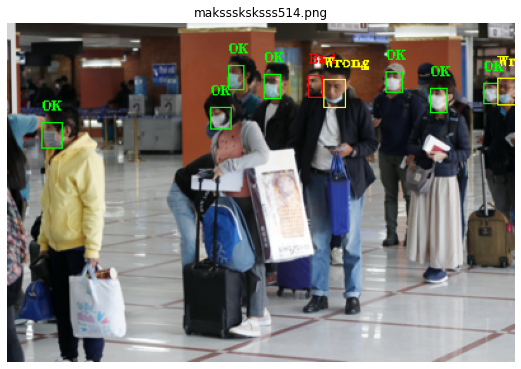

In [7]:
image_name = "maksssksksss514.png"
visualize_image(image_name)

# B- Building the Model
1. Create `Train/Test data` splits.
2. `configure` and `compile`
DarkNet
3. Create `_.names` file.
4. Create `_.data` file.
5. Create `train.txt` & `test.text` files.
6. Create `_.cfg` configuration file.

## B-1: Create `Train/Test Directories` with 90-10% split

In [8]:
# Where to copy files from.
ORIGINAL_PATH    = "/content/Graduation-Project/Phase 2 - YOLOv3/Face Mask Dataset/"
IMAGE_PATH       = ORIGINAL_PATH + "images/"                   # "Phase 2 - YOLOv3/Face Mask Dataset/images"

# Where to paste files in.
TRAIN_DEST = ORIGINAL_PATH + "Train/"
TEST_DEST  = ORIGINAL_PATH + "Test/"
#--- Directories creation
%mkdir -p "/content/Graduation-Project/Phase 2 - YOLOv3/Face Mask Dataset/Train/"
%mkdir -p "/content/Graduation-Project/Phase 2 - YOLOv3/Face Mask Dataset/Test/"


image_list = os.listdir(IMAGE_PATH) # Cpature the files names in the main directory
image_list.sort()                   # Sort to ensure that every image is followed by its annoations file.

train_list = image_list[:767*2]     # First 90% of the dataset, 767 Image + 767 annotation
test_list = image_list[767*2:]      # Final 10% of the dataset

### Train Split

In [9]:
#Train split
for i in range(0,len(train_list),2):
    img_src_file   = IMAGE_PATH + train_list[i]      # Image
    label_src_file = IMAGE_PATH + train_list[i + 1]  # Annotations

    # Copy image & annotation
    copy(img_src_file, TRAIN_DEST)
    copy(label_src_file, TRAIN_DEST)

### Test Split

In [10]:
#Test split
for i in range(0,len(test_list),2):
    img_src_file   = IMAGE_PATH + test_list[i]      # Image
    label_src_file = IMAGE_PATH + test_list[i + 1]  # Annotations

    # Copy image & annotation
    copy(img_src_file, TEST_DEST)
    copy(label_src_file, TEST_DEST)

In [11]:
print('Total Count :', len(image_list), "(853 * 2)")
print('Train       :', len(train_list), "(767 * 2)")
print('Test        :', len(test_list) , "(86 * 2)")

Total Count : 1706 (853 * 2)
Train       : 1534 (767 * 2)
Test        : 172 (86 * 2)


## B-2: `Configure` and `Compile` DarkNet

### **`Configure`**

In [12]:
# Configuration
# change makefile to have GPU and OPENCV enabled
%cd "/content/Graduation-Project/Phase 2 - YOLOv3/darknet"
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
# Note: -i flag means "inplace" changes.

/content/Graduation-Project/Phase 2 - YOLOv3/darknet


In [13]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


### **`Compile`**

Make darknet, builds darknet so that you can then use the darknet executable file to ***run*** or ***train*** object detectors.

In [14]:
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv

## B-3: Create `_.names` file.
Create a file **face_mask_detection.<b style="color: red">names</b>** which contains the classes of the problem.

**In our case, the original Kaggle dataset has 3 categories:**
* <b style="color: green">with_mask (OK)</b>
* <b style="color: red">without_mask (Bad)</b>
* <b style="color: orange">mask_weared_incorrect (Wrong)</b>

In [15]:
!echo -e 'OK\nBad\nWrong' > data/face_mask_detection.names

## B-4: Create `_.data` file.
Create a **face_mask_detection.<b style="color: red">data</b>** file that includes relevant information to our problem and it is going to be used from the program.
* classes = 3
* train = data/train.txt
* valid = data/test.txt
* names = data/face_mask_detection.names
* backup = backup/

**Note:** In case a ***backup folder does not exist***, create one, because there are going to be saved the weights every after 1000 iterations. These will actually be your checkpoints in case of an unexpected interruption, from where you can continue the training process.

In [16]:
!echo -e 'classes = 3\ntrain = data/train.txt\nvalid = data/test.txt\nnames = data/face_mask_detection.names\nbackup = backup/' > data/face_mask_detection.data
# -e flag enables the command echo to interpret special characters like "\n"

## B-5: Create `train.txt` & `test.text` files.
These two files have been included in the face_mask.data file and indicate the absolute path for each image to the model.

### **`Train.txt`**

In [17]:
images_list = glob.glob(TRAIN_DEST + "*.png")

with open("/content/Graduation-Project/Phase 2 - YOLOv3/darknet/data/train.txt", "w") as f:
    f.write("\n".join(images_list))

### **`Test.txt`**

In [18]:
images_list = glob.glob(TEST_DEST + "*.png")

with open("/content/Graduation-Project/Phase 2 - YOLOv3/darknet/data/test.txt", "w") as f:
    f.write("\n".join(images_list))

## B-6: Create `_.cfg` configuration file.
This configuration file has to be adjusted to our problem, namely we need to:
1. copy the `yolov3.cfg`
2. rename it into `face_mask_detection.cfg` 
3. apply the amendments as described below:
* Let `batch = 64`
* Let `subdivisions = 16` 
  * **Note:** in case Out of memory issue occurs increase this value to `32` or `64`.
* Let input dimensions to the default `width=416`, `height=416`.
* Let `max_batches = #classes * 2000`, thus **6000** iterations for our task.
* Use `ctrl+F` and search for the word “yolo”. This will lead you straight to the **`yolo_layers`** where you want to do 2 things.
  1. Change the number of classes, for our case classes=3.
  2. Change the number of filters right two variables above the [yolo] line.
    * This change has to be of `filters = (classes + 5) * 3`, namely `filters = (3 + 5) * 3 = 23` for our task.
    * In our .cfg file, there are 3 yolo_layers and thus you should do the aforementioned changes 3 times.

In [19]:
# Make a copy of yolov3.cfg with the name face_mask_detection.cfg
!cp cfg/yolov3.cfg cfg/face_mask_detection.cfg

In [20]:
# Change lines in yolov3.cfg file
!sed -i 's/batch=1/batch=64/' cfg/face_mask_detection.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/face_mask_detection.cfg
!sed -i 's/max_batches = 500200/max_batches = 6000/' cfg/face_mask_detection.cfg
!sed -i '610 s@classes=80@classes=3@' cfg/face_mask_detection.cfg
!sed -i '696 s@classes=80@classes=3@' cfg/face_mask_detection.cfg
!sed -i '783 s@classes=80@classes=3@' cfg/face_mask_detection.cfg
!sed -i '603 s@filters=255@filters=24@' cfg/face_mask_detection.cfg
!sed -i '689 s@filters=255@filters=24@' cfg/face_mask_detection.cfg
!sed -i '776 s@filters=255@filters=24@' cfg/face_mask_detection.cfg

In [ ]:
!zip -r darknet.zip "/content/Graduation-Project/Phase 2 - YOLOv3/darknet" 

# C- Training the Model
1. Download the starting point weights to train on your custom object detection task.
2. start actual training.

## C-1: Download Weights

In [22]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-07-14 00:12:20--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1 100%[===================>] 154.96M  68.1MB/s    in 2.3s    

2021-07-14 00:12:22 (68.1 MB/s) - ‘darknet53.conv.74.1’ saved [162482580/162482580]



In [23]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Wed Jul 14 00:12:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## C-2: Training

In [ ]:
#!./darknet detector train data/face_mask_detection.data cfg/face_mask_detection.cfg darknet53.conv.74 -dont_show -i 0 -map -points 0

# Uncomment below and comment above to re-start your training from last saved weights
#!./darknet detector train data/face_mask_detection.data cfg/face_mask_detection.cfg backup/face_mask_detection_best.weights -dont_show -i 0 -map -points 0

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.843697), count: 14, class_loss = 0.315953, iou_loss = 0.281844, total_loss = 0.597797 
 total_bbox = 1127575, rewritten_bbox = 0.057823 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.877392), count: 1, class_loss = 0.000000, iou_loss = 0.007564, total_loss = 0.007564 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.899064), count: 6, class_loss = 0.018351, iou_loss = 0.044558, total_loss = 0.062908 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.744000), count: 12, class_loss = 0.522200, iou_loss = 0.907398, total_loss = 1.429599 
 total_bbox = 1127594, rewritten_bbox = 0.057822 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.824267), count: 2, class_loss = 0.000003, iou_loss = 0.038777, total_loss = 0.038780 
v

## C-3: Testing

In [25]:
!./darknet detector test data/face_mask_detection.data cfg/face_mask_detection.cfg backup/face_mask_detection_best.weights
# Path: /content/Graduation-Project/Phase 2 - YOLOv3/Face Mask Dataset/images/maksssksksss514.png

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.59